# Document Embedding

The two key questions in Natural Language Processing (NLP) are:
- How do we represent words numerically in a text by maintaining its linguistic regularities and patterns?
- How do we represent documents numerically by retaining the semantics of the words and word orders in the document?

The first question can be addressed by creating word embedding using a technique named Word2vec. It was proposed in 2013 by a team of researchers led by Google’s Tomas Mikolov. It is described in the following notebook:
https://github.com/rhasanbd/Word-Embedding-by-Word2vec

The second question is addrssed by the same research group (Quoc Le and Tomas Mikolov) in 1994. They proposed a **Paragraph Vector** framework implemented by the **Doc2Vec** algorithm. It is an unsupervised framework to learn continuous distributed vector representations for pieces of texts.
https://cs.stanford.edu/~quocle/paragraph_vector.pdf


## Doc2vec: Main Idea

The Doc2vec model is created by slightly augmenting the Word2vec model. We only need to add an extra vector.

More formally it's a small extension to the Continuous Bag-of-Words (CBOW) Word2vec model. Instead of using just words to predict the next word, it also adds another feature vector, which is document-unique.

There are two implementations Doc2vec model:
- Distributed Memory (DM)
- Distributed Bag of Words (DBOW)


        Let's briefly describe the DM algorithm.


## Distributed Memory (DM) Algorithm

Consider the CBOW model as shown below. Three words (“the,” “cat,” and “sat”) are used to predict the fourth word (“on”). The input words are mapped to columns of the matrix W to predict the output word.

<img src="http://engineering.unl.edu/images/uploads/WordVector.png" width=400, height=150>


Here the word vectors are asked to contribute to a prediction task about the next word in the sentence. Despite the fact that the word vectors are initialized randomly, they can eventually capture semantics as an indirect result of the prediction task. 

In the DM algorithm, when training the word vectors W, the document vector D is trained as well, and in the end of training, it holds a numeric representation of the document.

See the DM Paragraph Vector framework below. Every paragraph is mapped to a unique vector, represented by a column in matrix D and every word is also mapped to a unique vector, represented by a column in matrix W . The paragraph vector and word vectors are averaged or concatenated to predict the next word in a context. 


<img src="http://engineering.unl.edu/images/uploads/ParagraphVector.png" width=400, height=150>

This model is called Distributed Memory version of Paragraph Vector (PV-DM) because it acts as a memory that remembers what is missing from the current context, or as the topic of the paragraph. 

While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.



## Experiment

We perform a text classification task to investigate the performance of the Doc2vec (PV-DM algorithm) technique. We use an email dataset for binary classification (spam and ham).

URL: https://www.kaggle.com/karthickveerakumar/spam-filter

The dataset consists of labeled emails belonging to both ham (label = 0) and spam (label = 1).

Previously we used Bag-of-Words based technique with Naive Bayes classifiers for classification on this dataset. We use it as a benchmark for comparison:
https://github.com/rhasanbd/Naive-Bayes-Algorithms-Foray-Into-Text-Classification/blob/master/Naive%20Bayes-Text%20Classification-Multinomial-Bernoulli.ipynb

In [1]:
import numpy as np
import pandas as pd
import warnings

import pickle

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Load Data

Load data from the CSV file as Pandas DataFrame object.

In [2]:
df = pd.read_csv('/Users/hasan/datasets/emails.csv')

# <font color=blue> 1. Exploratory Data Analysis</font>

## Quick Check of the Data

Let’s take a look at the top five rows using the DataFrame’s head() method.

In [3]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
text    5728 non-null object
spam    5728 non-null int64
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [5]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (5728, 2)

No. of Rows: 5728
No. of Columns: 2


## Class Distribution

In [6]:
df.groupby('spam').count()

,text
spam,
0,4360
1,1368


## Visualization of the Class Distribution

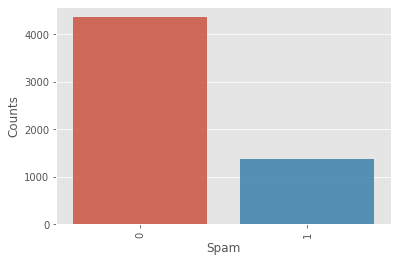

In [7]:
label_counts = df.spam.value_counts()
plt.figure(figsize = (6,4))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

## Create the Document Corpus

Get the "text" column of the DataFrame object as the corpus.

In [8]:
corpus = df['text']

print("Number of Documents (emails) in the Corpus: ", len(corpus))

#corpus[0]

Number of Documents (emails) in the Corpus:  5728


## Document Embedding using Doc2Vec

The Gensim Doc2vector model requires the corpus as a list of lists containing tokenized words per document and document tags, as shown below.

    ['feynman', 'teach', 'physic'], [0] 
    ['physic', 'cool'], [1]


Thus, before we perform document embedding, we need to **pre-process** the data by implementing the following steps:
- Create a list of documents
- Convert it to a list of lists containing tokenized words
- Create tagged documents with tokenized words

## Pre-process the Data


We pre-process the data as follows. 

- Convert to lowercase 
- Tokenize (split the documents into tokens or words)
- Remove numbers, but not words that contain numbers
- Remove words that are only one character
- Lemmatize the tokens/words


### Tokenization

We tokenize the text using a regular expression tokenizer from NLTK. We remove numeric tokens and tokens that are only a single character, as they don’t tend to be useful, and the dataset contains a lot of them.


The NLTK Regular-Expression Tokenizer class "RegexpTokenizer" splits a string into substrings using a regular expression. We use the regular expression "\w+" to matche token of words. 

- "\w" instructs to escape words.
- "+" is a quantifier that means 1 or more. 

See the following two links for a list of regular expressions and NLTK tokenize module.
https://github.com/tartley/python-regex-cheatsheet/blob/master/cheatsheet.rst
https://www.nltk.org/api/nltk.tokenize.html


## Function to Convert the 2D Document Array into a 2D Array of Tokenized Documents

- Note that we don't remove numbers and words with one characters for acieving better accuracy.

In [9]:
# Function for convert a list of sentences to a list of lists containing tokenized words
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+') # Tokenize the words.
    
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

## Convert the 2D Document Array into a 2D Array of Tokenized Words

In [10]:
%%time

# Convert a list of sentences to a list of lists containing tokenized words
docs = docs_preprocessor(corpus)
print(len(docs))


# Store the data locally
pickle.dump(docs, open("/Users/hasan/datasets_output/tokenized_spam_docs_large1_doc2vec.p", "wb" ) )

/Users/hasan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/hasan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


5728
CPU times: user 8min 46s, sys: 1.1 s, total: 8min 47s
Wall time: 8min 48s


## Compute Bigrams/Trigrams:


When topics are very similar, we may **use phrases** rather than single/individual words to distinguis each topic. 

Thus, we compute both bigrams (and may be trigrams). 
- Depending on the dataset it may not be necessary to create trigrams.

Note that we only keep the **frequent** phrases (bigrams/trigrams).

#### Bigrams
Bigrams are sets of two adjacent words. Using bigrams we can get phrases like “machine_learning” in our output (spaces are replaced with underscores). Without bigrams we would only get “machine” and “learning”.

- Note: we don't extract bigrams/trigrams. They don't increase accuracy of classification.

In [11]:
# from gensim.models import Phrases

# # Add bigrams and trigrams to docs (only ones that appear 10 times or more).
# bigram = Phrases(docs, min_count=10)
# trigram = Phrases(bigram[docs])

# for idx in range(len(docs)):
#     for token in bigram[docs[idx]]:
#         if '_' in token:
#             # Token is a bigram, add to document.
#             docs[idx].append(token)
#     for token in trigram[docs[idx]]:
#         if '_' in token:
#             # Token is a bigram, add to document.
#             docs[idx].append(token)

## Create Tagged Documents

For training the Doc2vec model, we need to create tagged documents.

A single document, made up of words and tags. 

In [12]:
# Load the list of lists containing tokenized words
#docs = pickle.load( open("/Users/hasan/datasets_output/tokenized_spam_docs_doc2vec.p", "rb" ) )
docs = pickle.load( open("/Users/hasan/datasets_output/tokenized_spam_docs_large1_doc2vec.p", "rb" ) )
#print(docs[0])

# Create Tagged documents
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
#print(documents[0])

## Training the Doc2vec Model

We use the gensim.models.Doc2Vec class.

        class gensim.models.doc2vec.Doc2Vec(documents=None, corpus_file=None, dm_mean=None, dm=1, dbow_words=0, dm_concat=0, dm_tag_count=1, docvecs=None, docvecs_mapfile=None, comment=None, trim_rule=None, callbacks=(), **kwargs)
        
We need to set the parameters of the Doc2Vec object carefully. The full list of the parameters are given:

https://radimrehurek.com/gensim/models/doc2vec.html

Below we discuss the settings of some of the key parameters.

- documents (iterable of list of TaggedDocument, optional)

        Input corpus, can be simply a list of elements.


- dm ({1,0}, optional)

        Defines the training algorithm. If dm=1, ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.

- vector_size (int, optional)

        Dimensionality of the feature vectors.

- window (int, optional)

        The maximum distance between the current and predicted word within a sentence.

- alpha (float, optional)

        The initial learning rate.

- min_alpha (float, optional)

        Learning rate will linearly drop to min_alpha as training progresses.

- seed (int, optional)

        Seed for the random number generator. Initial vectors for each word are seeded with a hash of the concatenation of word + str(seed). 
        

- min_count (int, optional)

        Ignores all words with total frequency lower than this.


- sample (float, optional)

        The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).


- workers (int, optional)

        Use these many worker threads to train the model (=faster training with multicore machines).


- epochs (int, optional)

        Number of iterations (epochs) over the corpus.

## Create the Doc2vec Model and Train

In [13]:
%%time
# Set training parameters
doc_vector_length = 300       # Dimension of the document vector
window_size = 2               # We set it 2 as the sentences weren't too long
epochs = 600                  # Number of iterations (epochs) over the corpus
min_count = 1                 # Ignores all words with total frequency lower than min_count
workers = 4                   # Number of worker threads to train the model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [14]:
%%time

# Create the Doc2vec model using gensim (If dm=1, ‘distributed memory’ (DM) algorithm is used)
model = Doc2Vec(vector_size=doc_vector_length, dm=1, window=window_size, min_count=min_count, 
                workers=workers, sample=0.01, epochs=epochs)
# Create vocabulary
model.build_vocab(documents)

# Train the model
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 20min 25s, sys: 55.1 s, total: 21min 20s
Wall time: 7min 18s


## Save the Model Locally

In [15]:
model.save('d2v_model_email_1')

## Load the Saved Model

In [16]:
# load doc2vec model
model = Doc2Vec.load('d2v_model_email_1')

## Vocabulary Size

In [17]:
print("Vocabulary Size: ", len(model.wv.vocab))

# print("Vocabulary: ")
# for word in model.wv.vocab:
#     print(" ", word)

Vocabulary Size:  28820


## Create Data Matrix X

In [18]:
noOfDocuments = len(documents)

X = np.empty([noOfDocuments, doc_vector_length])

for i in range(noOfDocuments):
    X[i] = model.docvecs[i].reshape(1, -1)
    
print(X.shape)
#print(X[0])

(5728, 300)


## Create Target (1D Vector y)

Get the "spam" column of the DataFrame object as the target vector.

In [19]:
y = df['spam'] # 1D targer vector

print(y.shape)

(5728,)


## Create Train and Test Dataset

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text Classification 

After embedding the text by using the Doc2vec model, we perform classification.

We use four classification models:
- Linear Support Vector Machine
- Non-Linear Support Vector Machine (Gaussian RBF Kernel)
- Logistic Regression
- Gaussian Naive Bayes Classifier


#### The optimal performance is achieved by the Linear SVM model. This is due to the linear separability of the data.


## Linear Support Vector Machine

The the LinearSVC class uses the Coordinate Descent approach. 

### Hyperparameter Settings:
- The "loss" hyperparameter should be set to "hinge".
- The hyperparameter "C" controls the penalty for the error (margin violation). It should be selected via grid search. We will investigate its effect shortly.
- Finally, for better performance we should set the "dual" hyperparameter to False, unless there are more features than training instances.

      Before applying SVM we need to standardize the features.

In [21]:
scaled_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(C=1, loss="hinge",  max_iter=5000, random_state=42))
    ])


scaled_svm_clf.fit(X_train, y_train)

y_train_predicted = scaled_svm_clf.predict(X_train)

/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [22]:
y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
print(scaled_svm_clf.score(X_test, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Ham", "Spam"]))


Test Accuracy:
0.9450261780104712

Test Confusion Matrix:
[[817  39]
 [ 24 266]]

Test Precision = 0.872131
Test Recall = 0.917241
Test F1 Score = 0.894118

Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      0.95      0.96       856
        Spam       0.87      0.92      0.89       290

    accuracy                           0.95      1146
   macro avg       0.92      0.94      0.93      1146
weighted avg       0.95      0.95      0.95      1146



## Non-linear SVM

We experiment with SVM Gaussian Radial Basis Function or RBF model. 


First, we find the optimal hyperparameters via grid search. Then, train a Gaussian RBF SVM model using the optimal hyperparameters.

However its performance is not as good as that of the linear SVM.

In [23]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'gamma': [0.00001, 0.0001, 0.01, 0.1], 'C': [1000, 500, 100, 10]}

svm_rbf_clf = SVC(kernel="rbf")

svm_cv = GridSearchCV(svm_rbf_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
svm_cv.fit(X_train, y_train)


params_optimal_svm = svm_cv.best_params_

print("Best Score: %f" % svm_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_svm)
print("\n")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.0min finished


Best Score: 0.932254
Optimal Hyperparameter Values:  {'C': 100, 'gamma': 0.0001}


CPU times: user 1.72 s, sys: 218 ms, total: 1.93 s
Wall time: 1min 1s


### Non-Linear SVM: Train the Optimal Model

In [24]:
svm_rbf = SVC(**params_optimal_svm)

svm_rbf.fit(X_train, y_train)

y_test_predicted = svm_rbf.predict(X_test)


print("\nTest Accuracy:")
print(svm_rbf.score(X_test, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Ham", "Spam"]))


Test Accuracy:
0.9703315881326352

Test Confusion Matrix:
[[843  13]
 [ 21 269]]

Test Precision = 0.953901
Test Recall = 0.927586
Test F1 Score = 0.940559

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       856
        Spam       0.95      0.93      0.94       290

    accuracy                           0.97      1146
   macro avg       0.96      0.96      0.96      1146
weighted avg       0.97      0.97      0.97      1146



## Logistic Regression

First, we perform hyperparameter tuning.

In [25]:
# %%time
# param_grid = {'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], 
#               'tol': [1e-3, 1e-4], 'max_iter':[3000, 5000, 10000],'C': [0.001, 0.1, 0.5, 1, 10]}

# lg_reg = LogisticRegression()

# lg_reg_cv = GridSearchCV(lg_reg, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
# lg_reg_cv.fit(X_train, y_train)

# params_optimal = lg_reg_cv.best_params_

# print("Best Score (accuracy): %f" % lg_reg_cv.best_score_)
# print("Optimal Hyperparameter Values: ", params_optimal)
# print("\n")

### Logistic Regression: Train the Optimal Model

In [26]:
# lg_reg_clf = LogisticRegression(**params_optimal)

# lg_reg_clf.fit(X_train, y_train)

In [27]:
# y_test_predicted = lg_reg_clf.predict(X_test)


# print("\nTest Accuracy:")
# print(lg_reg_clf.score(X_test, y_test))


# print("\nTest Confusion Matrix:")
# print(confusion_matrix(y_test, y_test_predicted))

# precision_test = precision_score(y_test, y_test_predicted) 
# print("\nTest Precision = %f" % precision_test)

# recall_test = recall_score(y_test, y_test_predicted)
# print("Test Recall = %f" % recall_test)


# f1_test = f1_score(y_test, y_test_predicted)
# print("Test F1 Score = %f" % f1_test)

# print("\nClassification Report:")
# print(classification_report(y_test, y_test_predicted, target_names = ["Ham", "Spam"]))

## Naive Bayes (Gaussian)

In [28]:
gaussianNB_clf = GaussianNB(var_smoothing=0.01).fit(X_train, y_train)

In [29]:
y_test_predicted = gaussianNB_clf.predict(X_test)


print("\nTest Accuracy:")
print(gaussianNB_clf.score(X_test, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Ham", "Spam"]))


Test Accuracy:
0.7164048865619547

Test Confusion Matrix:
[[625 231]
 [ 94 196]]

Test Precision = 0.459016
Test Recall = 0.675862
Test F1 Score = 0.546722

Classification Report:
              precision    recall  f1-score   support

         Ham       0.87      0.73      0.79       856
        Spam       0.46      0.68      0.55       290

    accuracy                           0.72      1146
   macro avg       0.66      0.70      0.67      1146
weighted avg       0.77      0.72      0.73      1146

